In [1]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
import shap
import pickle
import cloudpickle
import numpy as np
from comparers import ModelComparer
from explainers import generate_shap_explanations
from plots import plot_decision_boundary, plot_2d, plot_feature_importance_bar, plot_feature_importance_scatter,\
                  plot_feature_effects, plot_forces
from util import calc_feature_order, calc_class_order, calc_instance_order
import pandas as pd
import diro2c
from data_generation.helper import prepare_df
from data_generation.neighborhood_generation import neighbor_generator
from enums.diff_classifier_method_type import diff_classifier_method_type
from mlxtend.plotting import plot_decision_regions
from sklearn.tree import plot_tree
import rule_extractor
shap.initjs()
%matplotlib inline
task_name = '02'

In [2]:
with open(task_name + '.dataset', 'rb') as f:
    X, display_data, y, feature_names = pickle.load(f)
with open(task_name + '.models', 'rb') as f:
    comparer = pickle.load(f)

# Explain using Interpretability Methods

Prepare dataset for diro2c

In [3]:
idx_explain = 0

In [4]:
y = y.astype(str)
d = dict([(feature_name, feature_data)
          for feature_name, feature_data
          in zip(feature_names, [x for x in X.T])])
d |= {'y': y}
df = pd.DataFrame(d)
dataset = prepare_df(df, 'test', 'y')

## Binary difference explanations

In [5]:
%%time
diff_classifiers_info = diro2c.recognize_diff(idx_explain, X, dataset, comparer.clf_a, comparer.clf_b,
                                              diff_classifier_method_type.binary_diff_classifier,
                                              data_generation_function=neighbor_generator.get_genetic_neighborhood)

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


CPU times: user 12min 26s, sys: 48.1 s, total: 13min 14s
Wall time: 4min 20s


In [6]:
dc_info = diff_classifiers_info['binary_diff_classifer']
dc_full = dc_info['dc_full']
dc_test = dc_info['dc_test']
evaluation_info = dc_info['evaluation_info']

X_diff = evaluation_info['X']
y_diff = evaluation_info['y']

print(np.unique(y_diff, return_counts=True))

(array([0, 1]), array([1817,  659]))


In [7]:
value = 0
width = X.shape[0]
filler_feature_values = {1: value, 3: value, 4: value, 5: value, 6: value, 7: value, 8: value, 9: value, 10: value, 11: value}
filler_feature_ranges = {1: width, 3: width, 4: width, 5: width, 6: width, 7: width, 8: width, 9: width, 10: width, 11: width}

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
No contour levels were found within the data range.
Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.


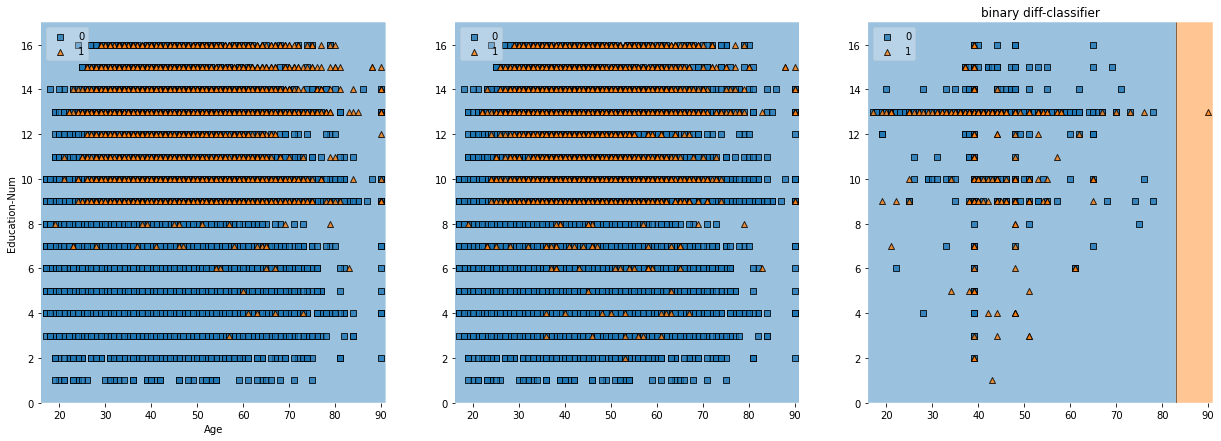

In [8]:
y_pred_a = comparer.clf_a.predict(X)
y_pred_b = comparer.clf_b.predict(X)

fig, ax = plt.subplots(1, 3, figsize=(21, 7))

fig = plot_decision_regions(X=X, y=y_pred_a.astype(np.int64), clf=comparer.clf_a, ax=ax[0], legend=2, feature_index=[0, 2], 
                            filler_feature_values=filler_feature_values, filler_feature_ranges=filler_feature_ranges)
ax[0].set_xlabel(feature_names[0])
ax[0].set_ylabel(feature_names[2])
plt.title('blackbox 1')

fig = plot_decision_regions(X=X, y=y_pred_b.astype(np.int64), clf=comparer.clf_b, ax=ax[1], legend=2, feature_index=[0, 2], 
                            filler_feature_values=filler_feature_values, filler_feature_ranges=filler_feature_ranges)
ax[0].set_xlabel(feature_names[0])
ax[0].set_ylabel(feature_names[2])
plt.title('blackbox 2')

fig = plot_decision_regions(X=X_diff, y=y_diff.astype(np.integer), clf=dc_full, ax=ax[2], legend=2, feature_index=[0, 2], 
                            filler_feature_values=filler_feature_values, filler_feature_ranges=filler_feature_ranges)
ax[0].set_xlabel(feature_names[0])
ax[0].set_ylabel(feature_names[2])
plt.title('binary diff-classifier')

plt.show()

[Text(468.5403745229008, 886.304347826087, 'Relationship <= 2.5\ngini = 0.391\nsamples = 2476\nvalue = [1817, 659]\nclass = no_diff'),
 Text(111.20288645038168, 846.9130434782609, 'Capital Gain <= 3880.0\ngini = 0.311\nsamples = 1529\nvalue = [1235, 294]\nclass = no_diff'),
 Text(37.86259541984733, 807.5217391304348, 'Capital Loss <= 1881.5\ngini = 0.026\nsamples = 838\nvalue = [827, 11]\nclass = no_diff'),
 Text(18.931297709923665, 768.1304347826087, 'Age <= 82.5\ngini = 0.002\nsamples = 826\nvalue = [825, 1]\nclass = no_diff'),
 Text(9.465648854961833, 728.7391304347826, 'gini = 0.0\nsamples = 825\nvalue = [825, 0]\nclass = no_diff'),
 Text(28.396946564885496, 728.7391304347826, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]\nclass = diff'),
 Text(56.79389312977099, 768.1304347826087, 'Capital Loss <= 2336.5\ngini = 0.278\nsamples = 12\nvalue = [2, 10]\nclass = diff'),
 Text(47.328244274809165, 728.7391304347826, 'gini = 0.0\nsamples = 10\nvalue = [0, 10]\nclass = diff'),
 Text(66.25954198

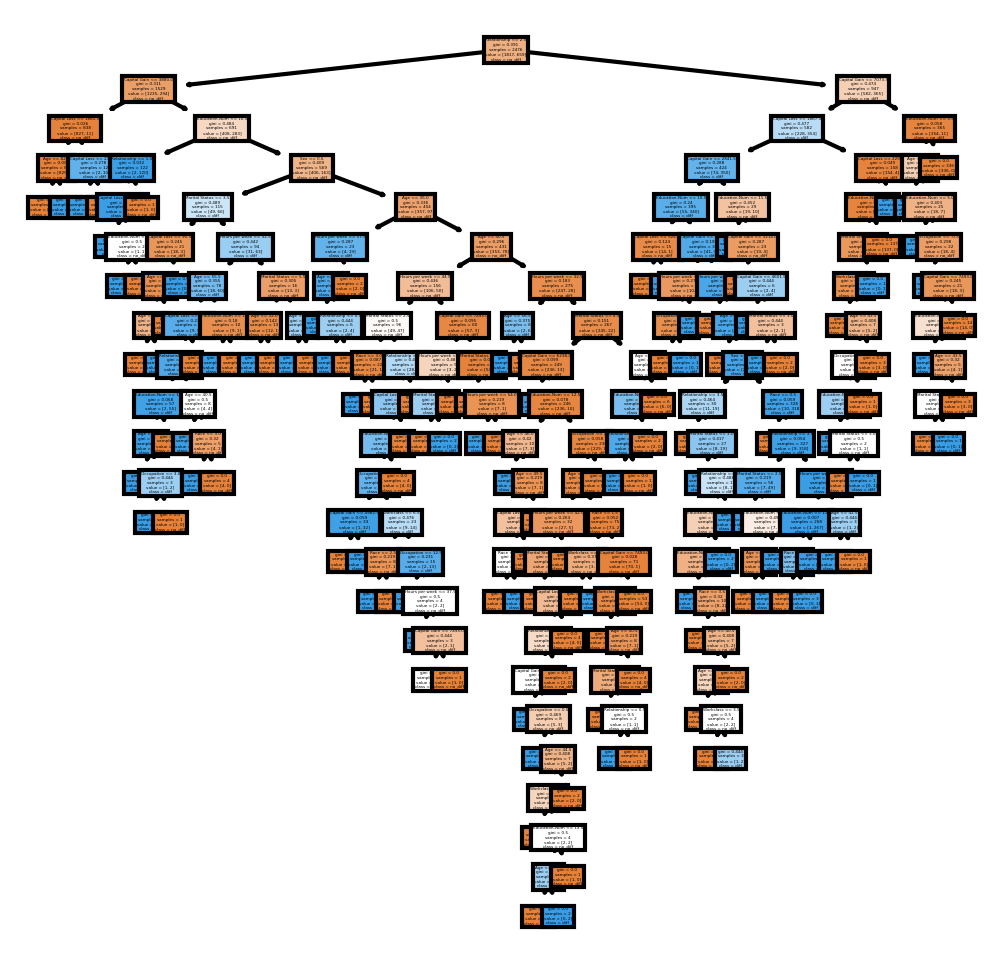

In [9]:
cn = ['no_diff', 'diff']
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4, 4), dpi=300)
plot_tree(dc_full,
               feature_names=feature_names,
               class_names=cn,
               filled=True)

In [10]:
rule_extractor.print_rules_for_binary(
    dc_full, dataset['columns_for_decision_rules'], ['no_diff', 'diff'], 'diff')

{'diff': '{Relationship <= 2.5, Capital Gain <= 3880.0, Capital Loss <= 1881.5, Age > 82.5}'}
{'diff': '{Relationship <= 2.5, Capital Gain <= 3880.0, Capital Loss > 1881.5, Capital Loss <= 2336.5}'}
{'diff': '{Relationship <= 2.5, Capital Gain > 3880.0, Education-Num <= 10.5, Relationship <= 1.5, Capital Loss <= 1211.0}'}
{'diff': '{Relationship <= 2.5, Capital Gain > 3880.0, Education-Num <= 10.5, Relationship <= 1.5, Capital Loss > 1211.0, Education-Num <= 7.0}'}
{'diff': '{Relationship <= 2.5, Capital Gain > 3880.0, Education-Num > 10.5, Sex <= 0.5, Marital Status <= 3.5, Capital Loss <= 90.5, Age <= 46.5, Age > 41.5}'}
{'diff': '{Relationship <= 2.5, Capital Gain > 3880.0, Education-Num > 10.5, Sex <= 0.5, Marital Status <= 3.5, Capital Loss > 90.5}'}
{'diff': '{Relationship <= 2.5, Capital Gain > 3880.0, Education-Num > 10.5, Sex <= 0.5, Marital Status > 3.5, Hours per week <= 52.5, Age <= 55.5, Capital Loss <= 1034.0, Relationship <= 0.5, Education-Num <= 15.0, Age <= 54.5}'}
{'d

## Multiclass difference explanations

In [11]:
multiclass_diff_names = ['(0, 0)', '(1, 1)', '(1, 0)', '(0, 1)']

In [12]:
%%time
diff_classifiers_info = diro2c.recognize_diff(idx_explain, X, dataset, comparer.clf_a, comparer.clf_b,
                                              diff_classifier_method_type.multiclass_diff_classifier,
                                              data_generation_function=neighbor_generator.get_genetic_neighborhood)

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


In [13]:
dc_info = diff_classifiers_info['multiclass_diff_classifer']
dc_full = dc_info['dc_full']
dc_test = dc_info['dc_test']
evaluation_info = dc_info['evaluation_info']

X_diff = evaluation_info['X']
y_diff = evaluation_info['y']

print(np.unique(y_diff, return_counts=True))

(array([1, 2, 3, 4]), array([1024,  796,  377,  248]))


No contour levels were found within the data range.
No contour levels were found within the data range.
You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.


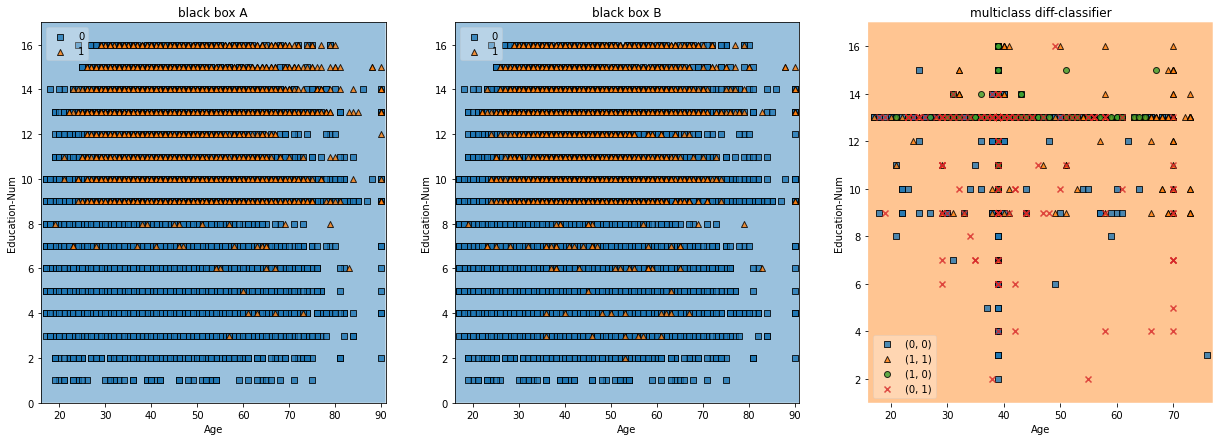

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(21, 7))

fig = plot_decision_regions(X=X, y=y_pred_a.astype(np.int64), clf=comparer.clf_a, ax=ax[0], legend=2,
                            hide_spines=False, feature_index=[0, 2], 
                            filler_feature_values=filler_feature_values, filler_feature_ranges=filler_feature_ranges)
ax[0].set_xlabel(feature_names[0])
ax[0].set_ylabel(feature_names[2])
ax[0].set_title('black box A')

fig = plot_decision_regions(X=X, y=y_pred_b.astype(np.int64), clf=comparer.clf_b, ax=ax[1], legend=2,
                            hide_spines=False, feature_index=[0, 2], 
                            filler_feature_values=filler_feature_values, filler_feature_ranges=filler_feature_ranges)
ax[1].set_xlabel(feature_names[0])
ax[1].set_ylabel(feature_names[2])
ax[1].set_title('black box B')

fig = plot_decision_regions(X=X_diff, y=y_diff.astype(np.int64), clf=dc_full, ax=ax[2], legend=2, feature_index=[0, 2], 
                            filler_feature_values=filler_feature_values, filler_feature_ranges=filler_feature_ranges)
ax[2].set_xlabel(feature_names[0])
ax[2].set_ylabel(feature_names[2])
ax[2].set_title('multiclass diff-classifier')

handles, labels = ax[2].get_legend_handles_labels()
ax[2].legend(handles,
             multiclass_diff_names,
             framealpha=0.3, scatterpoints=1)

plt.show()


[Text(406.1343914762742, 875.8, 'Capital Gain <= 4250.5\ngini = 0.685\nsamples = 2445\nvalue = [1024, 796, 377, 248]\nclass = (0, 0)'),
 Text(94.23605008787347, 815.4, 'Relationship <= 2.5\ngini = 0.412\nsamples = 1420\nvalue = [1022, 16, 375, 7]\nclass = (0, 0)'),
 Text(26.151142355008787, 755.0, 'Education-Num <= 15.5\ngini = 0.008\nsamples = 966\nvalue = [962, 0, 2, 2]\nclass = (0, 0)'),
 Text(13.075571177504393, 694.6, 'Capital Loss <= 1746.0\ngini = 0.002\nsamples = 961\nvalue = [960, 0, 0, 1]\nclass = (0, 0)'),
 Text(6.537785588752197, 634.2, 'gini = 0.0\nsamples = 955\nvalue = [955, 0, 0, 0]\nclass = (0, 0)'),
 Text(19.61335676625659, 634.2, 'Capital Gain <= 1087.0\ngini = 0.278\nsamples = 6\nvalue = [5, 0, 0, 1]\nclass = (0, 0)'),
 Text(13.075571177504393, 573.8, 'gini = 0.0\nsamples = 1\nvalue = [0, 0, 0, 1]\nclass = (0, 1)'),
 Text(26.151142355008787, 573.8, 'gini = 0.0\nsamples = 5\nvalue = [5, 0, 0, 0]\nclass = (0, 0)'),
 Text(39.22671353251318, 694.6, 'Sex <= 0.5\ngini = 0

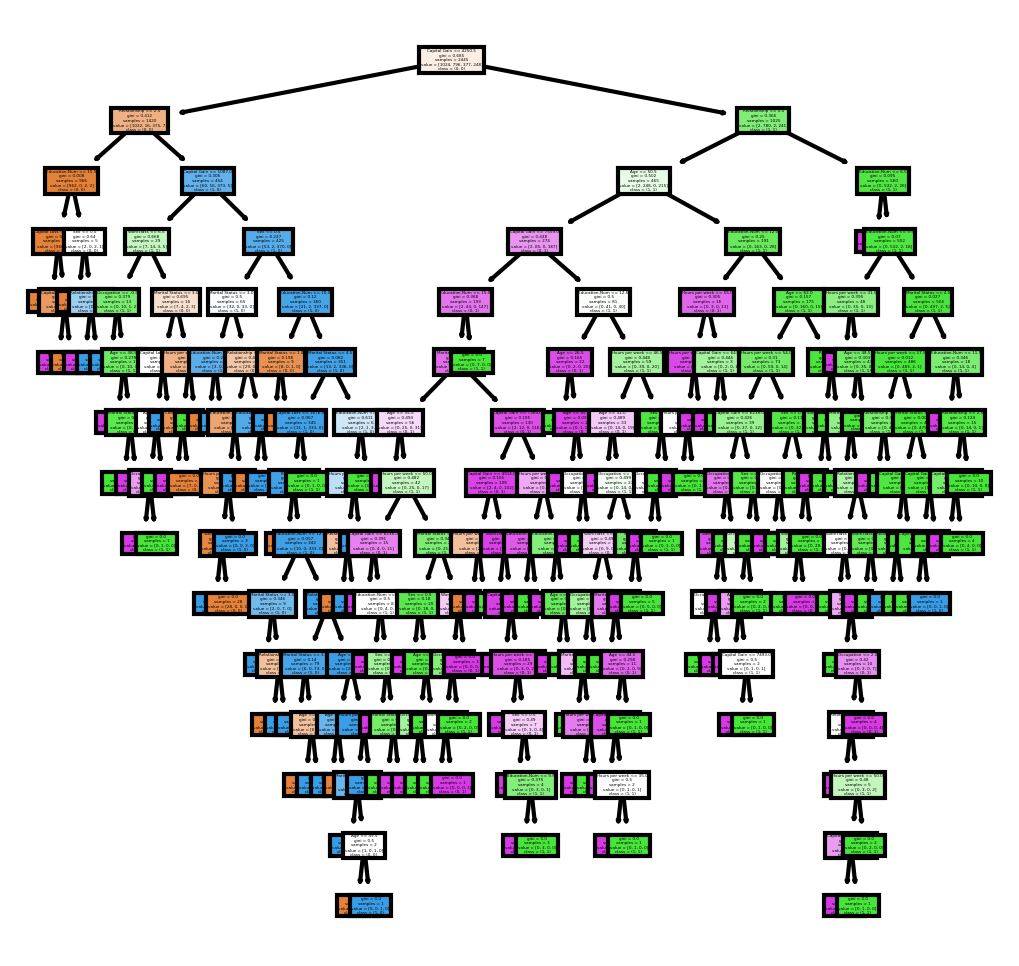

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4, 4), dpi=300)
plot_tree(dc_full,
               feature_names=feature_names,
               class_names=multiclass_diff_names,
               filled=True)